In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import copy
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import my_optim

import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

from gym.spaces.box import Box
from PIL import Image
from IPython.display import clear_output
from tqdm import trange


from material.atari_util import *

In [2]:
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = ""
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

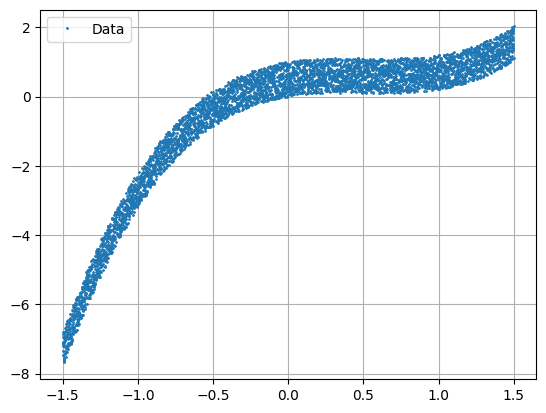

In [2]:
# 학습용도
x_train = np.linspace(-1.5,1.5,5000)
y_train = x_train**3-1.5*x_train**2+0.7*x_train+0.01*np.cos(x_train)+np.random.uniform(size=5000)
x_min,x_max = x_train.min(), x_train.max()
y_min,y_max = y_train.min(), y_train.max()
plt.plot(x_train,y_train,'o',markersize=1,label='Data')
plt.grid()
plt.legend()

In [3]:
from torch.utils.data import Dataset, DataLoader

def preprocess(x,y):
    x = (x-x_min)/(x_max-x_min)
    y = (y-y_min)/(y_max-y_min)
    return x,y

def postprocess(x,y):
    x = x*(x_max-x_min)+x_min
    y = y*(y_max-y_min)+y_min
    return x,y

class MyDataset(Dataset):
    def __init__(self,x,y):
        x,y = preprocess(x,y)
        self.x = x.reshape(-1,1)
        self.y = y.reshape(-1,1)
    def __getitem__(self,idx):
        return torch.FloatTensor(self.x[idx]), torch.FloatTensor(self.y[idx])
    def __len__(self):
        return len(self.x)
    
train_dataset = MyDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4)

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.lin1 = nn.Linear(1,64)
        self.lin2 = nn.Linear(64,64)
        self.lin3 = nn.Linear(64,64)
        self.lin4 = nn.Linear(64,1)
    def forward(self,x):
        x = F.elu(self.lin1(x))
        x = F.elu(self.lin2(x))
        x = F.elu(self.lin3(x))
        x = self.lin4(x)
        return x

In [4]:
#model = MyModel()
#optimizer = optim.Adam(model.parameters(),lr=1e-04)
#scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.7)

In [ ]:
#best_loss = np.inf
#for ep in range(500):
#    train_loss = 0
#    for x,y in train_dataloader:
#        y_infer = model(x)
#        loss = torch.mean((y-y_infer)**2)
#        optimizer.zero_grad()
#        loss.backward()
#        optimizer.step()
#        train_loss += loss.item()
#    train_loss/=len(train_dataloader)
#    if train_loss < best_loss:
#        best_loss = train_loss
#        best_model = copy.deepcopy(model)
#    if ep % 50 == 0:
#        print(f'   >  학습상황: {ep/500*100}%')
#        print(f'      >> 훈련오차: {train_loss}, 최저오차: {best_loss}')
#print(f'         >>> 학습종료')

   >  학습상황: 0.0%
      >> 훈련오차: 0.11117670828877371, 최저오차: 0.11117670828877371
   >  학습상황: 10.0%
      >> 훈련오차: 0.0012073006526614198, 최저오차: 0.0012051971051606197


In [ ]:
# 플롯 - 테스트 데이터 셋 확인
#x_test = np.linspace(-1.5,1.5,100)
#y_test = x_test**3-1.5*x_test**2+0.7*x_test+0.01*np.cos(x_test)
#x_test,y_test = preprocess(x_test,y_test)
#x_test = torch.Tensor(x_test).view(-1,1)
#y_test = torch.Tensor(y_test).view(-1,1)
#with torch.no_grad():
#    y_infer = model(x_test)
#    test_loss = torch.mean((y_infer-y_test)**2)
#print(f'   >  시험오차: {test_loss.item()}')
#x_test,y_infer = postprocess(x_test,y_infer)
#plt.plot(x_train,y_train,'o',markersize=1,label='Data')
#plt.plot(x_test.detach().cpu().numpy(),y_infer.detach().cpu().numpy(),label='Inference')
#plt.grid()
#plt.legend()

In [5]:
import os

# Multiprocessing
def train(rank,share_model,train_dataloader):
    print(f'시작 프로세스: {rank}')
    #optimizer = optim.Adam(share_model.parameters(),lr=1e-04)
    #scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.7)
    pid = os.getpid()
    best_loss = np.inf
    for ep in range(500):
        train_loss = 0
        for x,y in train_dataloader:
            y_infer = share_model(x)
            loss = torch.mean((y-y_infer)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss/=len(train_dataloader)
        if train_loss < best_loss:
            best_loss = train_loss
            best_model = copy.deepcopy(share_model)
        if ep % 50 == 0:
            print(f'   >  학습상황: {ep/500*100}%')
            print(f'      >> 훈련오차: {train_loss}, 최저오차: {best_loss}')
    print(f'         >>> 학습종료')
    
def test(share_model):
    x_test = np.linspace(-1.5,1.5,100)
    y_test = x_test**3-1.5*x_test**2+0.7*x_test+0.01*np.cos(x_test)
    x_test,y_test = preprocess(x_test,y_test)
    x_test = torch.Tensor(x_test).view(-1,1)
    y_test = torch.Tensor(y_test).view(-1,1)
    with torch.no_grad():
        y_infer = share_model(x_test)
        test_loss = torch.mean((y_infer-y_test)**2)
    print(f'   >  시험오차: {test_loss.item()}')
    x_test,y_infer = postprocess(x_test,y_infer)
    plt.plot(x_train,y_train,'o',markersize=1,label='Data')
    plt.plot(x_test.detach().cpu().numpy(),y_infer.detach().cpu().numpy(),label='Inference')
    plt.grid()
    plt.legend()

In [6]:
multi_model = MyModel()
optimizer = optim.Adam(multi_model.parameters(),lr=1e-04)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.7)
for rank in range(1):
    #train(rank,multi_model,train_dataloader)
    p = mp.Process(target=train,args=(rank,multi_model,train_dataloader))
    p.start()

시작 프로세스: 0
   >  학습상황: 0.0%
      >> 훈련오차: 0.32606665346818636, 최저오차: 0.32606665346818636
   >  학습상황: 10.0%
      >> 훈련오차: 0.0011404607462684943, 최저오차: 0.0011404607462684943
   >  학습상황: 20.0%
      >> 훈련오차: 0.0009688657717307723, 최저오차: 0.0009688657717307723
   >  학습상황: 30.0%
      >> 훈련오차: 0.0009312939298150566, 최저오차: 0.0009205417355369257
   >  학습상황: 40.0%
      >> 훈련오차: 0.0009195402609420162, 최저오차: 0.0008986989497442883
   >  학습상황: 50.0%
      >> 훈련오차: 0.0009054840870991443, 최저오차: 0.0008832670356253091
   >  학습상황: 60.0%
      >> 훈련오차: 0.0009004606701775536, 최저오차: 0.0008832670356253091
   >  학습상황: 70.0%
      >> 훈련오차: 0.0008905773276545674, 최저오차: 0.0008832670356253091
   >  학습상황: 80.0%
      >> 훈련오차: 0.0009055582473431773, 최저오차: 0.0008816322373650685
   >  학습상황: 90.0%
      >> 훈련오차: 0.000896432667622885, 최저오차: 0.0008788854635285238
         >>> 학습종료


   >  시험오차: 0.7608965039253235


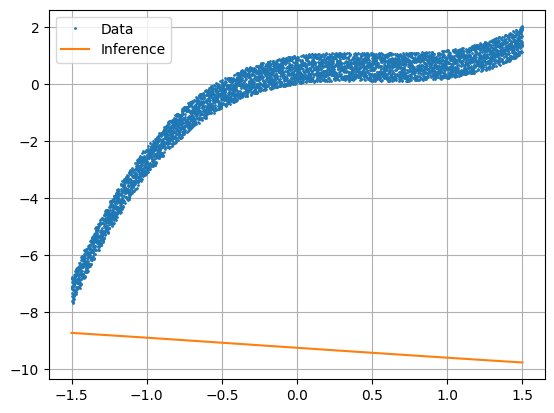

In [7]:
test(multi_model)

In [ ]:

#mp.set_start_method("forkserver")
share_model = MyModel()
share_model.share_memory()|
optimizer = optim.Adam(multi_model.parameters(),lr=1e-04)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma=0.7)

num_processes = 4
processes = []
for rank in range(num_processes):
    p = mp.Process(target=train,args=(rank,multi_model,train_dataloader))
    p.start()
    processes.append(p)

for p in processes:
    p.join()
    
test(multi_model)

In [ ]:
import torch
import torch.multiprocessing as mp

def compute(x):
    value = x*x
    print(value)
    return value

# Define the input data
data = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8])
# Create a new process
p = mp.Process(target=compute, args=(data,))
# Start the process
p.start()
# Wait for the process to finish
p.join()
# Print the result
mp.Value

In [ ]:
data

In [3]:
# GPU 장치는 A3C에 적용할수 없습니다.
device = torch.device('cpu')

State shape: (210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


(-0.5, 159.5, 209.5, -0.5)

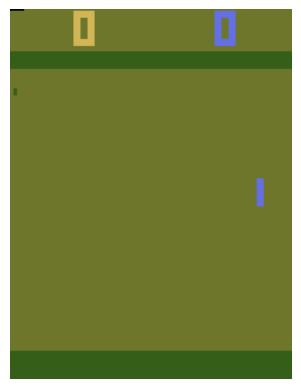

In [4]:
env_name = 'PongDeterministic-v4'
#env_name = 'Pong-v4'
#env_name = 'Breakout-v0'
env = gym.make(env_name)
state = env.reset()

print(f'State shape: {state.shape}')
img = env.render('rgb_array')
plt.imshow(img)
plt.axis('off')

6
NOOP
FIRE
RIGHT
LEFT
RIGHTFIRE
FIRE
RIGHT
LEFT
RIGHTFIRE
LEFTFIRE


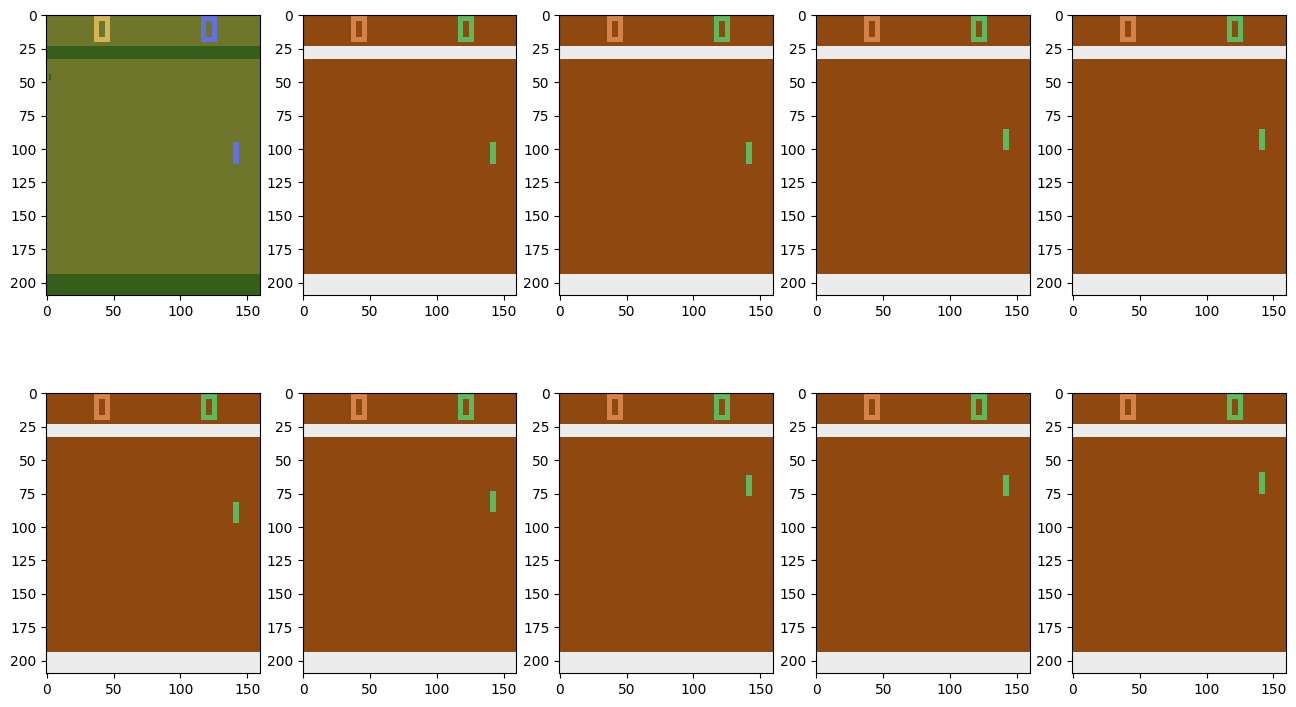

In [5]:
print(env.action_space.n)
n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        ax.imshow(obs, interpolation='none')
        obs, _, _, _ = env.step((row+col)%10)
        print(env.unwrapped.get_action_meanings()[(row+col)%10])
plt.show()

# Pong environment preprocess

In [6]:
from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size,dtype=np.float32)

    def _to_gray_scale(self, rgb, channel_weights=[0.7, 0.1, 0.2]):
        dummy = 0
        for idx,channel_weight in enumerate(channel_weights):
            dummy += channel_weight*(rgb[:,:,idx])
        return np.expand_dims(dummy,axis=-1)
    
    def observation(self, img):      
        img = Image.fromarray(np.uint8(img),'RGB')
        img = img.resize((64,64))
        img = np.array(img)
        img = self._to_gray_scale(img)/255.
        return np.array(img,dtype=np.float32).transpose((2,0,1))

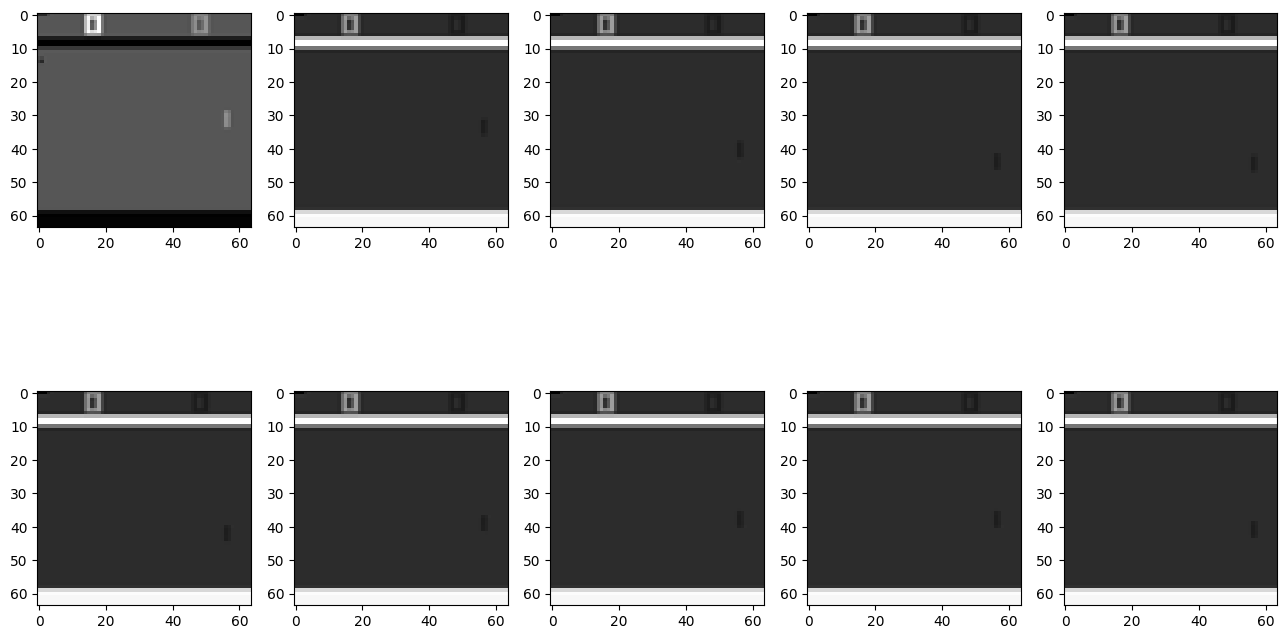

In [7]:
env = gym.make(env_name) 
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

In [8]:
from material.atari_wrapper import *

def PrimaryAtariWrap(env,clip_rewards=True):
    env = MaxAndSkipEnv(env, skip=4) # 설명 : 지나치게 빠른 프레임 -> 4 프레임씩 자르기
    env = EpisodicLifeEnv2(env)       # 설명 라이프 모두 소진시 에피소드 종료
    env = FireResetEnv(env)          # 설명 : 라이프 소진시 자동으로 새 게임 시작(발사)
    if clip_rewards:                 # 설명: 보상에 대한 clipping, 처벌: -1, 보상: +1 로 reward 범위 제한
        env = ClipRewardEnv(env)
    env = PreprocessAtariObs(env)    # 이미지 전처리
    return env

In [9]:
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)     
        n_channels, height, width = env.observation_space.shape
        obs_shape = [n_channels * n_frames, height, width]
        self.observation_space = Box(0.0, 1.0, obs_shape, dtype=np.float32)
        self.framebuffer = np.zeros(obs_shape)

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        offset = self.env.observation_space.shape[0]
        cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=0)

In [10]:
def make_env(clip_rewards=True, seed=None):
    env = gym.make('PongDeterministic-v4') 
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4)
    return env

In [11]:
env = make_env(True,123)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

(4, 64, 64)
(4, 64, 64)


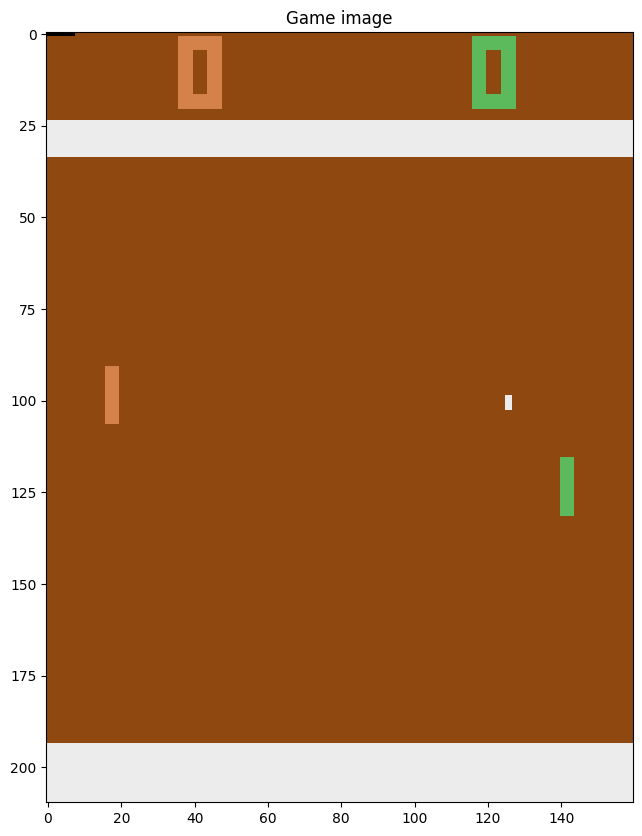

(4, 64, 64)


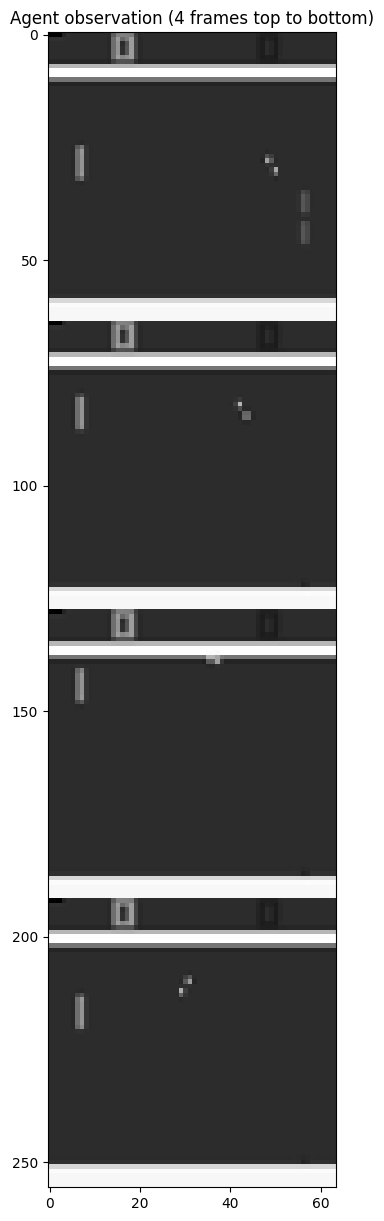

(4, 64, 64)
(256, 64)


In [12]:
def img_by_obs(obs, state_dim):
    """
    Unwraps obs by channels.
    observation is of shape [c, h=w, w=h]
    """
    print(obs.shape)
    return obs.reshape([-1, state_dim[2]])

for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

state_shape = env.observation_space.shape

print(obs.shape)
print(state_shape)
plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(img_by_obs(obs, state_shape), cmap='gray')
plt.show()
dummy = img_by_obs(obs,state_shape)
print(dummy.shape)

In [13]:
class A3C_Agent(nn.Module):
    def __init__(self,num_actions):
        super(A3C_Agent,self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(4,32,5,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,5,stride=2),
            nn.ReLU(),
            nn.Conv2d(64,64,5,stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1600,256),
            nn.ReLU(),
        )
        #self.conv1 = nn.Conv2d(4,32,5,stride=2)
        #self.conv2 = nn.Conv2d(32,64,5,stride=2)
        #self.conv3 = nn.Conv2d(64,64,5,stride=2)
        #self.ReLU = nn.ReLU()
        #self.lin1 = nn.Linear(1600,256)
        self.policy = nn.Linear(256,num_actions)
        self.value = nn.Linear(256,1)

    def forward(self, state_t):
        '''
        입력인자
            state_t : 상태([batch,state_shape]), torch.tensor
        출력인자
            policy : 정책([batch,n_actions]), torch.tensor
            value : 가치함수([batch]), torch.tensor
        '''
        #print(f'forward 체크: {state_t.shape}')
        policy = self.policy(self.seq(state_t))    
        #print(f'forward 체크: {policy.shape}')
        value = self.value(self.seq(state_t)).squeeze(dim=-1)
        #print(f'forward 체크: {value.shape}')
        return policy, value
        #print(f'forward 체크: {state_t.shape}')
        #hidden1 = self.ReLU(self.conv1(state_t))
        #print(f'forward 체크: {hidden1.shape}')
        #hidden2 = self.ReLU(self.conv2(hidden1))
        #hidden3 = self.ReLU(self.conv3(hidden2)).view(-1,1600)
        #print(f'forward 체크: {hidden3.shape}')
        #FC = self.ReLU(self.lin1(hidden3))
        #print(f'forward 체크: {FC.shape}')
        #policy = self.policy(FC)
        #value = self.value(FC)
        #return policy, value
    
    def sample_actions(self,state_t):
        '''
        입력인자
            state_t : 상태([1,state_shape]), torch.tensor
        출력인자
            action_t : 행동함수 using torch.multinomial
        '''
        policy, _ = self.forward(state_t)
        policy = torch.squeeze(policy)
        softmax_policy = F.softmax(policy,dim=0)
        action = torch.multinomial(softmax_policy, num_samples=1).item()
        return action

In [14]:
def A2C_loss(transition,train_agent,env,gamma=0.99):
    '''
    A2C loss함수 계산코드
    입력인자
        batch_sample - 리플레이로부터 받은 샘플(S,A,R,S',done)
        train_agent - 훈련에이전트
        env - 환경
        gamma - 할인율
    출력인자
        Total_loss
    목적함수 
        -log(policy)*advantage + (value_infer-value_target)**2 + policy*log(policy)
        Actor-loss(exploitation): "log(policy)*advantage"
        Actor-entropy(exploration): "policy*log(policy)"
        Critic-loss: "MSE(value_infer - value_target)"
    '''
    states,actions,rewards,next_state,done = transition
    
    states = torch.Tensor(states[None]).to(device)
    #actions = torch.Tensor(actions).to(device).view(-1,num_action)
    rewards = torch.Tensor(rewards[None]).to(device)
    next_state = torch.Tensor([next_state]).to(device)
    policies, values = train_agent(states)
    _, next_value = train_agent(next_state)
    if done:
        next_value = 0
    
    probs = F.softmax(policies,dim=-1)
    logprobs = F.log_softmax(policies,dim=-1)

    target_values = rewards+gamma*next_value
    
    advantages = target_values - values
    entropy = -torch.sum(probs*logprobs,dim=-1)

    actor_loss = -torch.mean(logprobs*advantages + epsilon*entropy)
    critic_loss = F.mse_loss(target_values.detach(),values)
    total_loss = actor_loss + critic_loss
    return total_loss, actor_loss, critic_loss

In [20]:
#def A3C_train(shared_agent,env,process_number):
    #agent = A3C_Agent(n_actions)
    #optimizer = optim.Adam(shared_agent.parameters(),lr=learning_rate)
    #scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)
    #agent.load_state_dict(shared_agent.state_dict())
def A3C_train(shared_agent,optimimzer,process_number):
    env = make_env(True,123+process_number)
    
    reward_record, TDloss_record, ACloss_record, CRloss_record = [], [], [], []
    for ep in range(max_episode):
        print(f'에피소드: {ep} - 프로세스: {process_number}')
        done = False
        state = env.reset()
        cnt = 0
        total_reward = 0
        total_episode_TD = 0
        total_episode_acloss = 0
        total_episode_crloss = 0
        
        while True:
            torch_state = torch.Tensor(state).to(device)
            torch_state = torch.unsqueeze(torch_state,0)
            action = shared_agent.sample_actions(torch_state)
            #action,value = train_agent(torch_state)
            print('돌아가냐?4')
            next_state,reward,done,_ = env.step(action)
            total_reward += reward
            
            transition = (state,action,np.array([reward]),next_state,done)
            loss,actor_loss,critic_loss = A2C_loss(transition,shared_agent,env,gamma)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_episode_TD += loss.item()
            total_episode_acloss += actor_loss.item()
            total_episode_crloss += critic_loss.item()
            print('돌아가냐?3')
            if done:
                ep +=1 
                TDloss_record.append(total_episode_TD/cnt)
                ACloss_record.append(total_episode_acloss/cnt)
                CRloss_record.append(total_episode_crloss/cnt)
                reward_record.append(total_reward)
                if total_reward == 20:
                    best_agent = copy.deepcopy(shared_agent)
                break
            
            # 업데이트
            state = next_state
            cnt += 1
            
        if ep % 10 == 0:
            #clear_output(True)
            print(f'{ep}번째 에피소드 결과 - 프로세스: {process_number}')
            print(f'최근 10 에피소드 보상평균 = {np.mean(reward_record[-10:])}')
            print(f'최근 10 에피소드 A2C오차 = {np.mean(TDloss_record[-10:])}')
            
        if np.mean(reward_record[-10:]) >= 20:
            print(f"충분한 보상: {np.mean(reward_record[-10:])}")
            print(f"학습종료 - 프로세스: {process_number}")
            break

In [15]:
learning_rate = 1e-04
step_size=1e+05
gamma=0.99
max_episode= 10000000

In [21]:
env = make_env(True,123)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

train_agent = A3C_Agent(n_actions).to(device)
train_agent.share_memory()
#optimizer = optim.Adam(train_agent.parameters(),lr=learning_rate)
optimizer = my_optim.SharedAdam(train_agent.parameters(), lr=learning_rate)
optimizer.share_memory()
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)

In [22]:
processes = []
num_processes = 4 #  일반적 4코어
for rank in range(num_processes):
    #p = mp.Process(target=A3C_train, args=(train_agent,env,rank))
    p = mp.Process(target=A3C_train, args=(train_agent,optimizer,rank))
    p.start()
    processes.append(p)
for p in processes:
    p.join()
    
best_agent = copy.deepcopy(train_agent)

에피소드: 0 - 프로세스: 0
에피소드: 0 - 프로세스: 1
에피소드: 0 - 프로세스: 2
에피소드: 0 - 프로세스: 3


In [ ]:
import gym.wrappers

def record(state,agent,env,vid):
    reward = 0

    while True:
        vid.capture_frame()
        torch_state = torch.Tensor(state).to(device)
        torch_state = torch.unsqueeze(torch_state,0)
        action = agent.sample_actions(torch_state)
        state,r,done,_ = env.step(action) 
        
        reward += r
        #print(reward,done)
        if done:
            break
    vid.close()
    return reward

env = make_env(clip_rewards=True,seed=12)
vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,path='./videos/Pong/A3CPong_best.mp4')
vid.render_mode="rgb_array"
state = env.reset()
#rewards = record(state,best_agent,env,vid)
rewards = record(state,train_agent,env,vid)
print(rewards)

In [ ]:
from IPython.display import Video

#Video('./videos/atari_breakout/Your_agent.mp4',embed=True,width=512, height=512)
#Video('./videos/atari_breakout/Fullgame_Your_agent.mp4',embed=True,width=512, height=512)
Video('./videos/Pong/A3CPong_best.mp4',embed=True,width=512, height=512)
#Video('./videos/atari_breakout/Best_agent_vol2.mp4',embed=True,width=512, height=512)

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.lin1 = nn.Linear(1,64)
        self.lin2 = nn.Linear(64,32)
        self.lin3 = nn.Linear(32,1)
        #self.lin4 = nn.Linear(32,1)
        #self.ELU = nn.functional.elu()
        self.policy = nn.Linear(32,6)
        self.value = nn.Linear(32,1)

    def forward(self,x):
        h = nn.functional.elu(self.lin1(x))
        #print(f'중간출력')
        h = nn.functional.elu(self.lin2(h))
        policy = self.policy(h)
        value = self.value(h)
        #x = self.lin3(h)
        #y = self.lin4(h)
        return policy, value

    #def sample_actions(self,x):
    #    '''
    #    입력인자
    #        state_t : 상태([1,state_shape]), torch.tensor
    #    출력인자
    #        action_t : 행동함수 using torch.multinomial
    #    '''
    #    policy, _ = self.forward(x)
    #    policy = torch.squeeze(policy)
    #    softmax_policy = F.softmax(policy,dim=0)
    #    action = torch.multinomial(softmax_policy, num_samples=1).item()
    #    return action

In [ ]:
def sample_actions(policy):
    policy = torch.squeeze(policy)
    softmax_policy = F.softmax(policy,dim=0)
    #action = torch.multinomial(softmax_policy, num_samples=1).item()
    action = torch.argmax(softmax_policy).item()
    return action

In [ ]:
model = MyModel()
model.share_memory()
optimizer = optim.Adam(model.parameters(),lr=1e-04)

In [ ]:
def train(model,process):
    print(f'시작체크: {process}')
    x = torch.Tensor(size=(1,1))
    for i in range(10):
        outx, outy = model(x)
        print(f'결과체크: {outx.shape}, {outy.shape}')
        #action = sample_actions(outx)
        action = F.softmax(outx,dim=0)
        action = torch.multinomial(action,1)
        print(f'액션: {action.data}')
        #action = model.sample_actions(x)
        lossp = torch.mean((outx-1)**2)
        lossv = torch.mean((outy+1)**2)
        loss = lossp+lossv
        #loss = lossp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'최적화?ㅇㅋ')
        print(f'손실함수: {loss.item()}')
    return outx,outy


In [ ]:
num_processes = 4
processes = []
for rank in range(num_processes):
    p = mp.Process(target=train,args=(model,rank))
    p.start()
    processes.append(p)

for p in processes:
    p.join()